In [ ]:
# PARTIE 0 – IMPORTS & CHARGEMENT

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# --------- CHARGEMENT DU FICHIER ---------

path = r"C:\Users\admin\Desktop\insurance_claims.csv"

try:
    df = pd.read_csv(path, na_values='?')   # on gère déjà les "?"
    print(f"Fichier chargé avec succès. Taille initiale: {df.shape}")
except FileNotFoundError:
    print(f"ERREUR : fichier introuvable à l'adresse : {path}")
    raise

df.head()


✅ Fichier chargé avec succès. Taille initiale: (1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,NaN,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [20]:
# PARTIE 1 – NETTOYAGE DE BASE

# 1) suppression de la colonne poubelle
if '_c39' in df.columns:
    df.drop('_c39', axis=1, inplace=True)

# 2) remplissage des NaN par "Unknown" pour certaines colonnes
cols_to_fix = ['collision_type', 'property_damage',
               'police_report_available', 'authorities_contacted']

for col in cols_to_fix:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

# 3) colonnes à retirer (peu informatives ou identifiants)
cols_to_remove = [
    'policy_number',
    'incident_location',
    'total_claim_amount',
    'insured_zip',
    'auto_year'
]

for col in cols_to_remove:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

print("Dimensions après nettoyage de base :", df.shape)

# Vérification des valeurs manquantes restantes
print("\nValeurs manquantes restantes :")
print(df.isna().sum()[df.isna().sum() > 0])


Dimensions après nettoyage de base : (1000, 34)

Valeurs manquantes restantes :
Series([], dtype: int64)


In [21]:
# PARTIE 2 – EDA 1 : APERÇU GLOBAL

print("Aperçu des 5 premières lignes :")
display(df.head())

print("\nTypes de variables :")
print(df.dtypes)

print("\nStatistiques descriptives (numériques) :")
display(df.describe())

print("\nValeurs manquantes par colonne (si > 0) :")
missing = df.isna().sum()
display(missing[missing > 0])


Aperçu des 5 premières lignes :


,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,...,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,fraud_reported
0,328,48,2014-10-17,OH,250/500,1000,1406.91,0,MALE,MD,...,YES,1,2,YES,6510,13020,52080,Saab,92x,Y
1,228,42,2006-06-27,IN,250/500,2000,1197.22,5000000,MALE,MD,...,Unknown,0,0,Unknown,780,780,3510,Mercedes,E400,Y
2,134,29,2000-09-06,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,...,NO,2,3,NO,7700,3850,23100,Dodge,RAM,N
3,256,41,1990-05-25,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,...,Unknown,1,2,NO,6340,6340,50720,Chevrolet,Tahoe,Y
4,228,44,2014-06-06,IL,500/1000,1000,1583.91,6000000,MALE,Associate,...,NO,0,1,NO,1300,650,4550,Accura,RSX,N



Types de variables :
months_as_customer               int64
age                              int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_hour_of_the_day         int64
number_of_vehicles_involved      int64
property_damage                 object
bod

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,1136.000000,1256.406150,1.101000e+06,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,7433.420000,7399.570000,37928.950000
std,115.113174,9.140287,611.864673,244.167395,2.297407e+06,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,4880.951853,4824.726179,18886.252893
min,0.000000,19.000000,500.000000,433.330000,-1.000000e+06,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,70.000000
25%,115.750000,32.000000,500.000000,1089.607500,0.000000e+00,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,4295.000000,4445.000000,30292.500000
50%,199.500000,38.000000,1000.000000,1257.200000,0.000000e+00,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,6775.000000,6750.000000,42100.000000
75%,276.250000,44.000000,2000.000000,1415.695000,0.000000e+00,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,11305.000000,10885.000000,50822.500000
max,479.000000,64.000000,2000.000000,2047.590000,1.000000e+07,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,21450.000000,23670.000000,79560.000000



Valeurs manquantes par colonne (si > 0) :


Series([], dtype: int64)

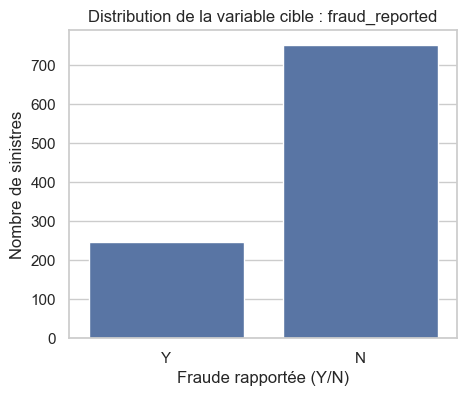

fraud_reported
N    753
Y    247
Name: count, dtype: int64

Répartition en pourcentage :
fraud_reported
N    0.753
Y    0.247
Name: proportion, dtype: float64


In [ ]:
# PARTIE 3 – EDA 2 : DISTRIBUTION DE fraud_reported

if 'fraud_reported' in df.columns:
    plt.figure(figsize=(5, 4))
    sns.countplot(x='fraud_reported', data=df)
    plt.title("Distribution de la variable cible : fraud_reported")
    plt.xlabel("Fraude rapportée (Y/N)")
    plt.ylabel("Nombre de sinistres")
    plt.show()

    print(df['fraud_reported'].value_counts())
    print("\nRépartition en pourcentage :")
    print(df['fraud_reported'].value_counts(normalize=True).round(3))
else:
    print("La colonne 'fraud_reported' n'est pas présente.")


Colonnes numériques : ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'injury_claim', 'property_claim', 'vehicle_claim']


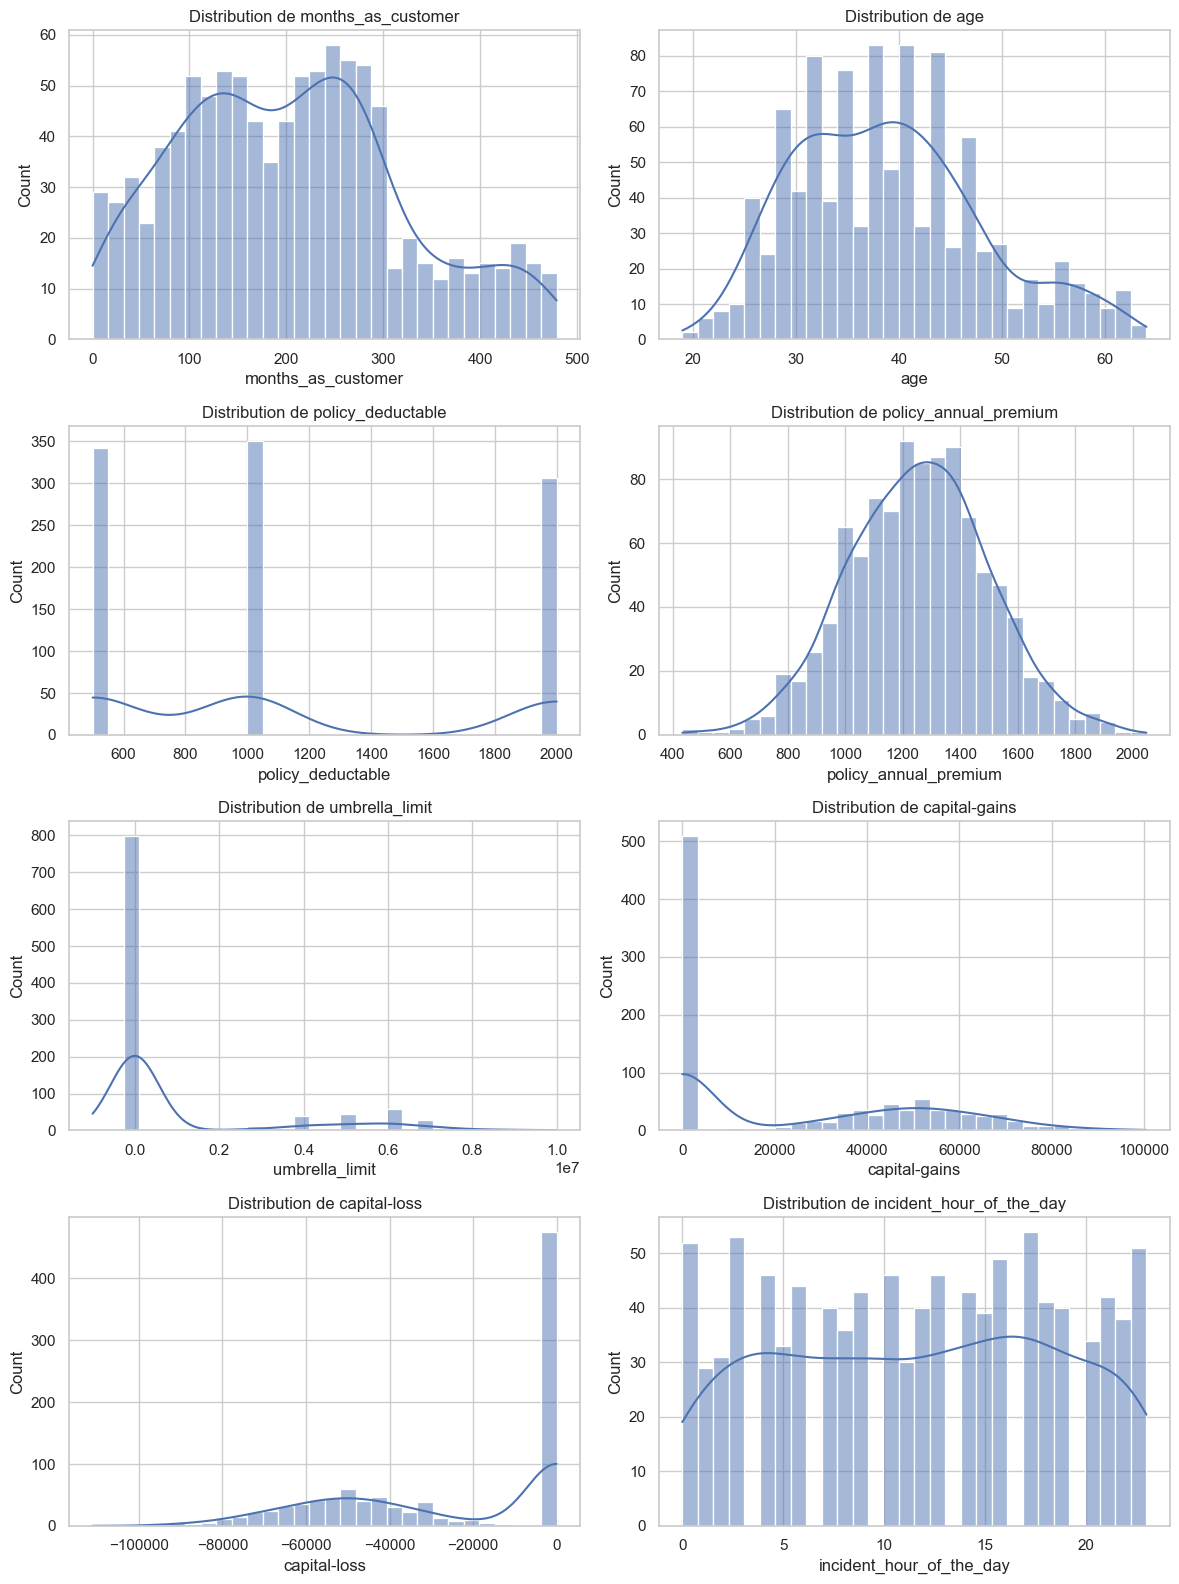

In [23]:
# PARTIE 4 – EDA 3 : DISTRIBUTION DES VARIABLES NUMÉRIQUES

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Colonnes numériques :", numeric_cols)

# on enlève la cible si elle est numérique
if 'fraud_reported' in numeric_cols:
    numeric_cols.remove('fraud_reported')

numeric_cols_to_plot = numeric_cols[:8]  # limite à 8 pour l'affichage

n_cols = 2
n_rows = int(np.ceil(len(numeric_cols_to_plot) / n_cols))

plt.figure(figsize=(12, 4 * n_rows))

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


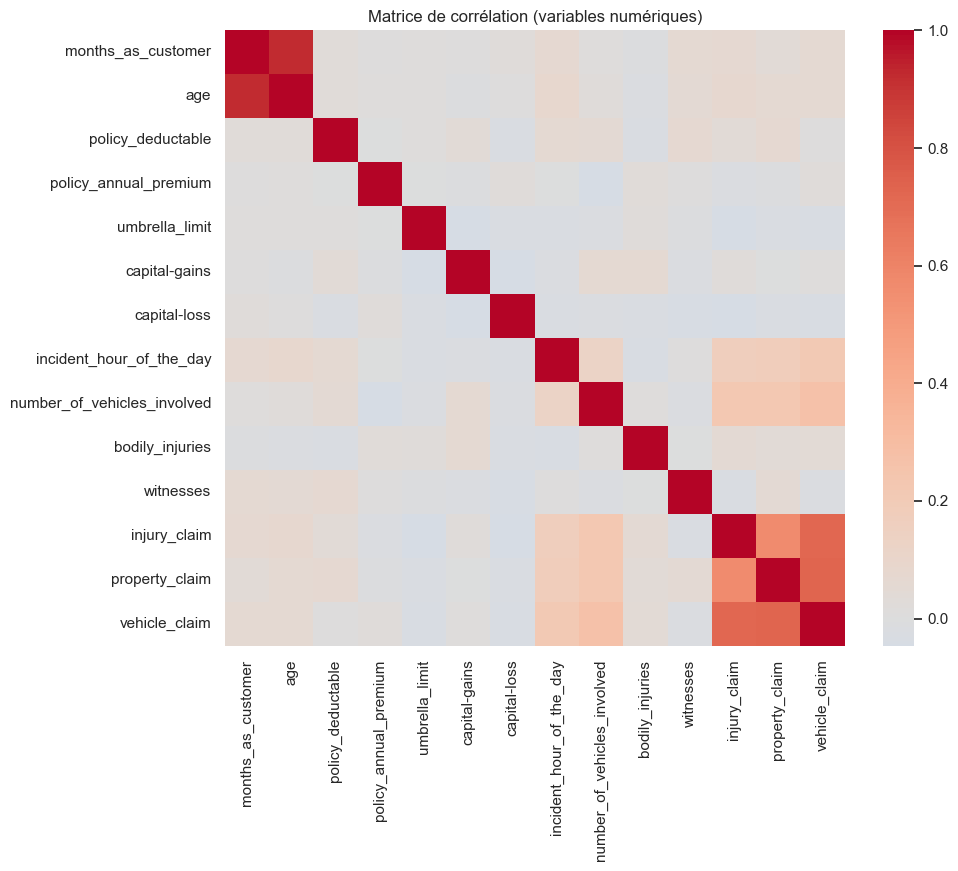

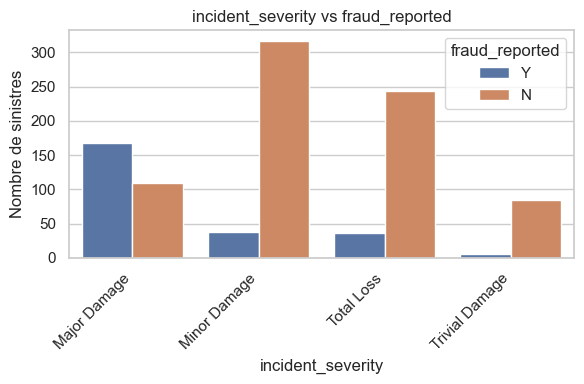

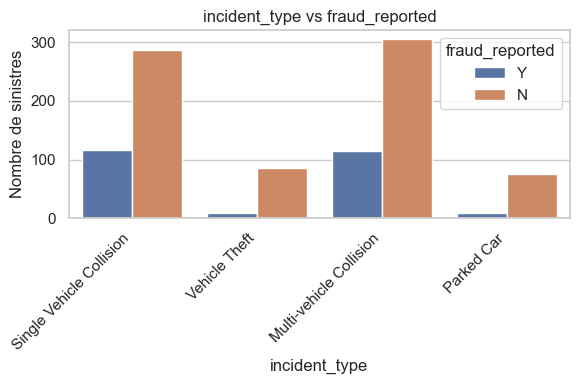

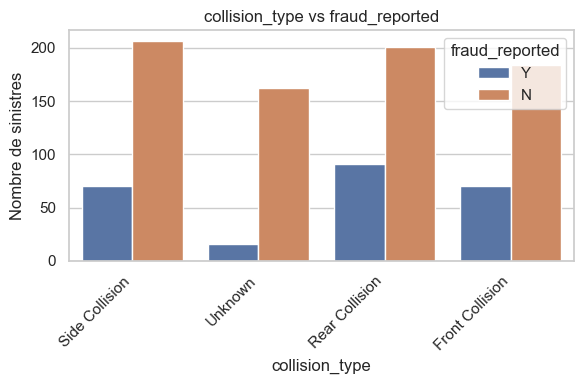

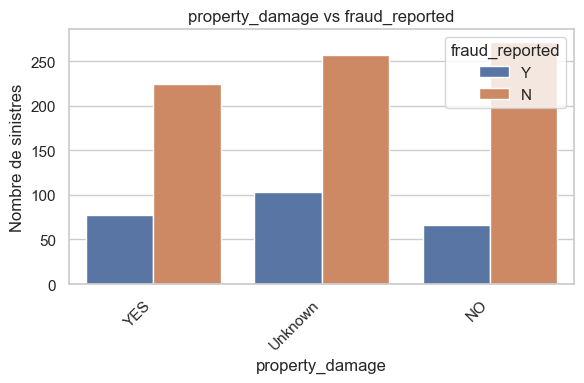

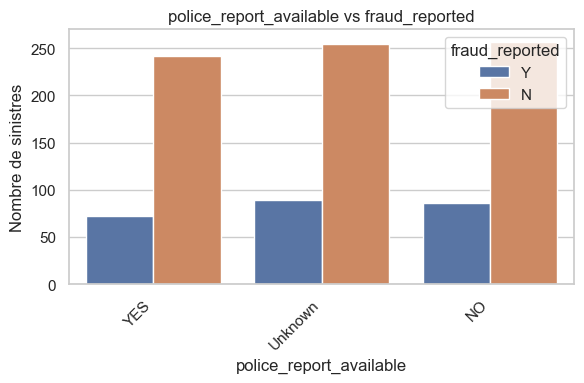

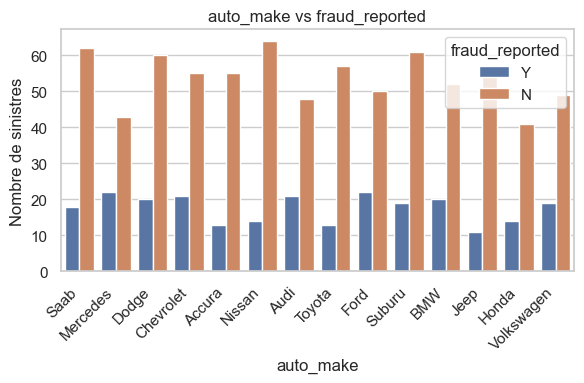

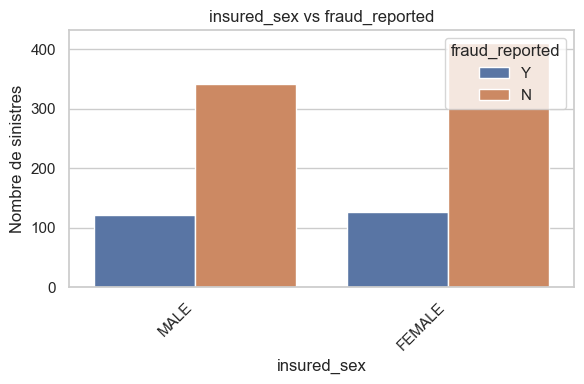

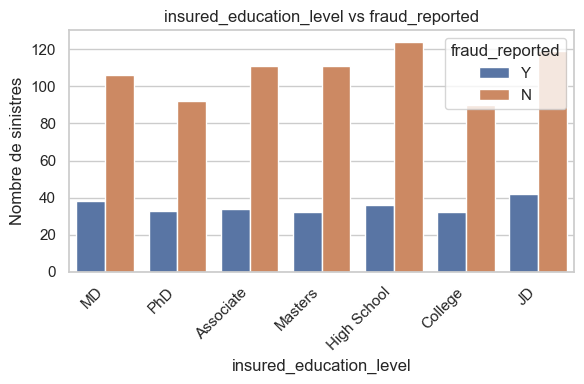

In [24]:
# PARTIE 5 – EDA 4 : CORRÉLATION & LIEN AVEC LA FRAUDE

# Matrice de corrélation
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Matrice de corrélation (variables numériques)")
    plt.show()
else:
    print("Pas assez de variables numériques pour une matrice de corrélation.")

# Relations avec la fraude pour quelques variables catégorielles
cat_cols_candidates = [
    'incident_severity',
    'incident_type',
    'collision_type',
    'property_damage',
    'police_report_available',
    'auto_make',
    'insured_sex',
    'insured_education_level'
]

cat_cols_to_plot = [c for c in cat_cols_candidates if c in df.columns]

for col in cat_cols_to_plot:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='fraud_reported', data=df)
    plt.title(f"{col} vs fraud_reported")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Nombre de sinistres")
    plt.legend(title="fraud_reported")
    plt.tight_layout()
    plt.show()


count    1.000000e+03
mean     1.101000e+06
std      2.297407e+06
min     -1.000000e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: umbrella_limit, dtype: float64


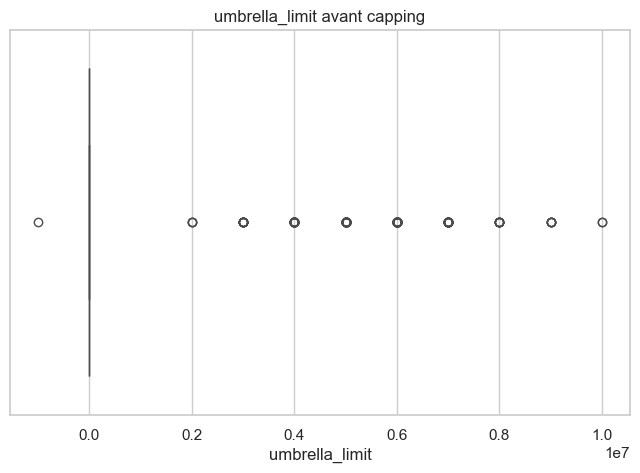

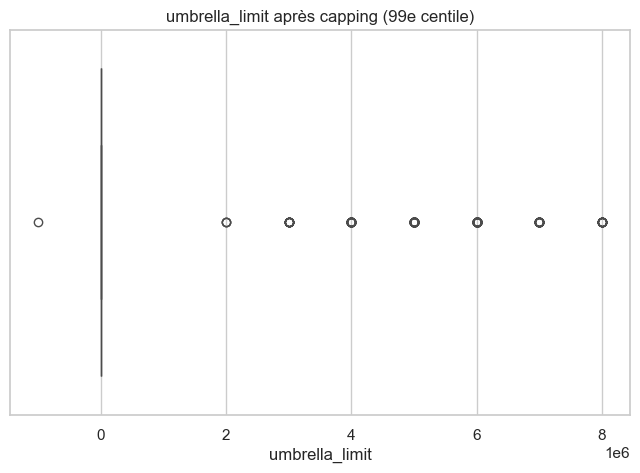

In [25]:
# PARTIE 6 – TRAITEMENT DES OUTLIERS SUR umbrella_limit

if 'umbrella_limit' in df.columns:
    print(df['umbrella_limit'].describe())

    plt.figure()
    sns.boxplot(x=df['umbrella_limit'])
    plt.title("umbrella_limit avant capping")
    plt.show()

    upper_limit = df['umbrella_limit'].quantile(0.99)
    df.loc[df['umbrella_limit'] > upper_limit, 'umbrella_limit'] = upper_limit

    plt.figure()
    sns.boxplot(x=df['umbrella_limit'])
    plt.title("umbrella_limit après capping (99e centile)")
    plt.show()
else:
    print("Pas de colonne 'umbrella_limit' dans le dataframe.")


In [26]:
# PARTIE 7 – PRÉPARATION DES DONNÉES & SMOTE

# Encodage de la cible
df['fraud_reported'] = df['fraud_reported'].map({'N': 0, 'Y': 1})

y = df['fraud_reported']
X = df.drop('fraud_reported', axis=1)

# suppression des dates
date_cols = ['policy_bind_date', 'incident_date', 'date_of_birth']
for col in date_cols:
    if col in X.columns:
        X.drop(col, axis=1, inplace=True)

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

print("Shape de X après encodage :", X.shape)

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train :", X_train.shape, "Test :", X_test.shape)
print("Répartition y_train :")
print(y_train.value_counts(normalize=True))

# Standardisation
X_train = X_train.copy()
X_test = X_test.copy()

num_cols = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

# SMOTE sur le train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Après SMOTE – X_train_res :", X_train_res.shape)
print("Répartition y_train_res :")
print(y_train_res.value_counts())


Shape de X après encodage : (1000, 142)
Train : (700, 142) Test : (300, 142)
Répartition y_train :
fraud_reported
0    0.752857
1    0.247143
Name: proportion, dtype: float64
Après SMOTE – X_train_res : (1054, 142)
Répartition y_train_res :
fraud_reported
0    527
1    527
Name: count, dtype: int64


In [27]:
# PARTIE 8 – DÉFINITION DES MODÈLES & FONCTION D'ÉVALUATION

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    "SVM": SVC(
        kernel='rbf', class_weight='balanced', probability=True, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, class_weight='balanced', random_state=42
    )
}

voting_clf = VotingClassifier(
    estimators=[(name.replace(" ", "_"), m) for name, m in models.items()],
    voting='soft'
)
models["Voting Classifier"] = voting_clf


def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    else:
        y_proba = None
        roc = np.nan

    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec  = recall_score(y_te, y_pred)
    f1   = f1_score(y_te, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Precision : {prec:.3f}")
    print(f"Recall    : {rec:.3f}")
    print(f"F1-score  : {f1:.3f}")
    print(f"ROC-AUC   : {roc:.3f}")
    print("\nClassification report :")
    print(classification_report(y_te, y_pred))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc
    }


In [28]:
# PARTIE 9 – ENTRAÎNEMENT DES MODÈLES & TABLEAU COMPARATIF

results = []

for name, model in models.items():
    res = evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print("\nRésumé des performances (trié par F1) :")
results_df



=== Logistic Regression ===
Accuracy  : 0.800
Precision : 0.621
Recall    : 0.486
F1-score  : 0.545
ROC-AUC   : 0.826

Classification report :
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       226
           1       0.62      0.49      0.55        74

    accuracy                           0.80       300
   macro avg       0.73      0.69      0.71       300
weighted avg       0.79      0.80      0.79       300


=== SVM ===
Accuracy  : 0.757
Precision : 0.526
Recall    : 0.135
F1-score  : 0.215
ROC-AUC   : 0.760

Classification report :
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       226
           1       0.53      0.14      0.22        74

    accuracy                           0.76       300
   macro avg       0.65      0.55      0.54       300
weighted avg       0.71      0.76      0.70       300


=== Random Forest ===
Accuracy  : 0.770
Precision : 0.568
Recall    : 0.2

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.800000,0.620690,0.486486,0.545455,0.826238
3,Voting Classifier,0.790000,0.634146,0.351351,0.452174,0.816073
2,Random Forest,0.770000,0.567568,0.283784,0.378378,0.778462
1,SVM,0.756667,0.526316,0.135135,0.215054,0.760344


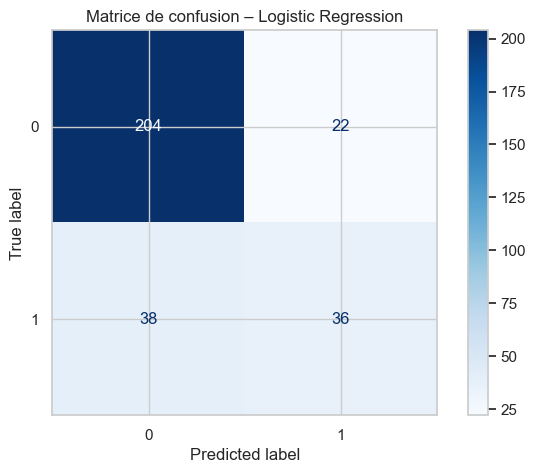

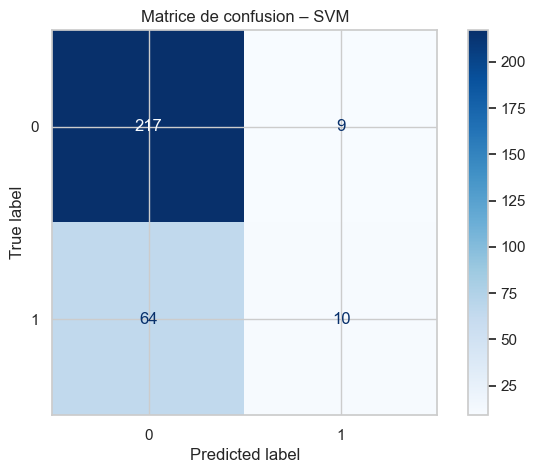

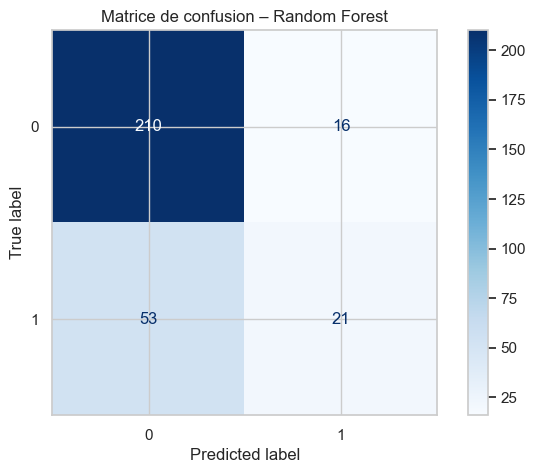

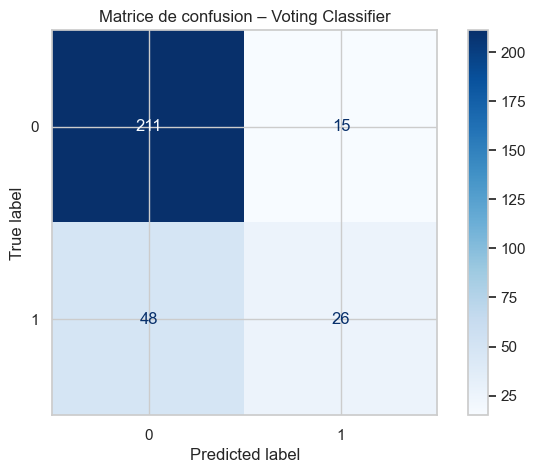

In [29]:
# PARTIE 10 – MATRICES DE CONFUSION

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matrice de confusion – {name}")
    plt.show()


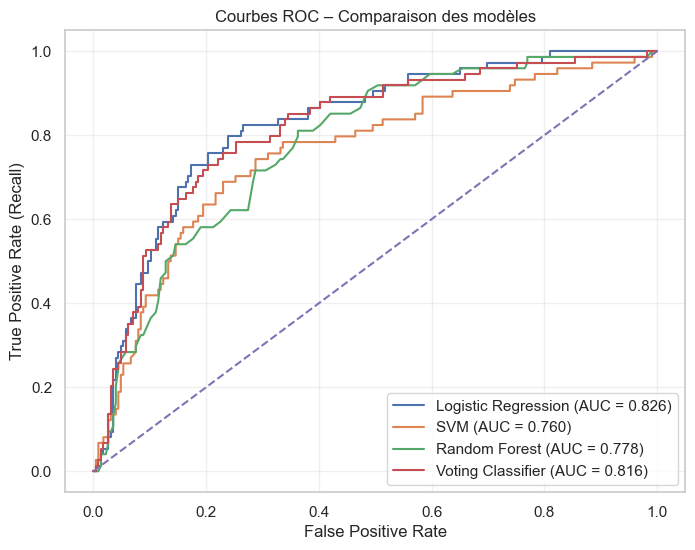

In [37]:
# PARTIE 11 – COURBES ROC (TOUS LES MODÈLES) + AUC

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # 1) entraînement sur train rééquilibré
    model.fit(X_train_res, y_train_res)

    # 2) score continu (proba ou décision)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise ValueError(f"{name} n'a ni predict_proba ni decision_function.")

    # 3) ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# diagonale (modèle aléatoire)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Courbes ROC – Comparaison des modèles")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [31]:
# PARTIE 13 – VALIDATION CROISÉE MULTI-MÉTRIQUES DES MODÈLES

from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = []

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_res,
        y_train_res,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    cv_results.append({
        "Model": name,
        "Accuracy_mean": scores['test_accuracy'].mean(),
        "Accuracy_std": scores['test_accuracy'].std(),
        "Precision_mean": scores['test_precision'].mean(),
        "Precision_std": scores['test_precision'].std(),
        "Recall_mean": scores['test_recall'].mean(),
        "Recall_std": scores['test_recall'].std(),
        "F1_mean": scores['test_f1'].mean(),
        "F1_std": scores['test_f1'].std(),
        "ROC_AUC_mean": scores['test_roc_auc'].mean(),
        "ROC_AUC_std": scores['test_roc_auc'].std()
    })
    
    print(f"\n{name}")
    for metric in scoring.keys():
        print(
            f"{metric.upper()} : "
            f"{scores[f'test_{metric}'].mean():.3f} "
            f"(± {scores[f'test_{metric}'].std():.3f})"
        )

cv_results_df = pd.DataFrame(cv_results).sort_values(
    by="F1_mean", ascending=False
)

cv_results_df



Logistic Regression
ACCURACY : 0.888 (± 0.010)
PRECISION : 0.910 (± 0.024)
RECALL : 0.863 (± 0.041)
F1 : 0.885 (± 0.014)
ROC_AUC : 0.959 (± 0.010)

SVM
ACCURACY : 0.917 (± 0.010)
PRECISION : 0.963 (± 0.009)
RECALL : 0.869 (± 0.029)
F1 : 0.913 (± 0.013)
ROC_AUC : 0.978 (± 0.009)

Random Forest
ACCURACY : 0.929 (± 0.014)
PRECISION : 0.951 (± 0.026)
RECALL : 0.905 (± 0.027)
F1 : 0.927 (± 0.015)
ROC_AUC : 0.980 (± 0.009)

Voting Classifier
ACCURACY : 0.922 (± 0.008)
PRECISION : 0.936 (± 0.024)
RECALL : 0.907 (± 0.013)
F1 : 0.921 (± 0.006)
ROC_AUC : 0.979 (± 0.008)


,Model,Accuracy_mean,Accuracy_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std,ROC_AUC_mean,ROC_AUC_std
2,Random Forest,0.928842,0.014376,0.951193,0.026278,0.905031,0.027173,0.927000,0.015067,0.980057,0.009159
3,Voting Classifier,0.922198,0.007730,0.936397,0.024023,0.906972,0.012929,0.921106,0.006465,0.978841,0.008096
1,SVM,0.917463,0.010163,0.962561,0.009265,0.869003,0.029290,0.912983,0.012557,0.977903,0.008829
0,Logistic Regression,0.888057,0.010096,0.909809,0.023539,0.863306,0.041317,0.884779,0.014281,0.959020,0.009506


In [32]:
final_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

final_model.fit(X_train_res, y_train_res)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
# PARTIE 7 – ÉVALUATION FINALE SUR LE TEST (DONNÉES RÉELLES)

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# Modèle final (choisi après CV)
final_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

# Entraînement final sur TOUT le train rééquilibré
final_model.fit(X_train_res, y_train_res)

# Prédictions sur le test réel
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Rapport de classification
print("=== ÉVALUATION FINALE – RANDOM FOREST ===\n")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC :", round(roc_auc, 3))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion :\n", cm)


=== ÉVALUATION FINALE – RANDOM FOREST ===

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       226
           1       0.57      0.28      0.38        74

    accuracy                           0.77       300
   macro avg       0.68      0.61      0.62       300
weighted avg       0.74      0.77      0.74       300

ROC-AUC : 0.778

Matrice de confusion :
 [[210  16]
 [ 53  21]]


In [34]:
# PARTIE 8 – ANALYSE DE SEUIL

from sklearn.metrics import precision_score, recall_score, f1_score

seuils = [0.5, 0.4, 0.3]

print("\n=== ANALYSE DE SEUIL – RANDOM FOREST ===")

for seuil in seuils:
    y_pred_seuil = (y_proba >= seuil).astype(int)
    
    print(f"\nSeuil = {seuil}")
    print("Precision :", round(precision_score(y_test, y_pred_seuil), 3))
    print("Recall    :", round(recall_score(y_test, y_pred_seuil), 3))
    print("F1        :", round(f1_score(y_test, y_pred_seuil), 3))
    print("Confusion matrix :")
    print(confusion_matrix(y_test, y_pred_seuil))



=== ANALYSE DE SEUIL – RANDOM FOREST ===

Seuil = 0.5
Precision : 0.553
Recall    : 0.284
F1        : 0.375
Confusion matrix :
[[209  17]
 [ 53  21]]

Seuil = 0.4
Precision : 0.494
Recall    : 0.581
F1        : 0.534
Confusion matrix :
[[182  44]
 [ 31  43]]

Seuil = 0.3
Precision : 0.401
Recall    : 0.824
F1        : 0.54
Confusion matrix :
[[135  91]
 [ 13  61]]


X_test_sample shape: (200, 142)
shap_values_class1 shape: (200, 142)


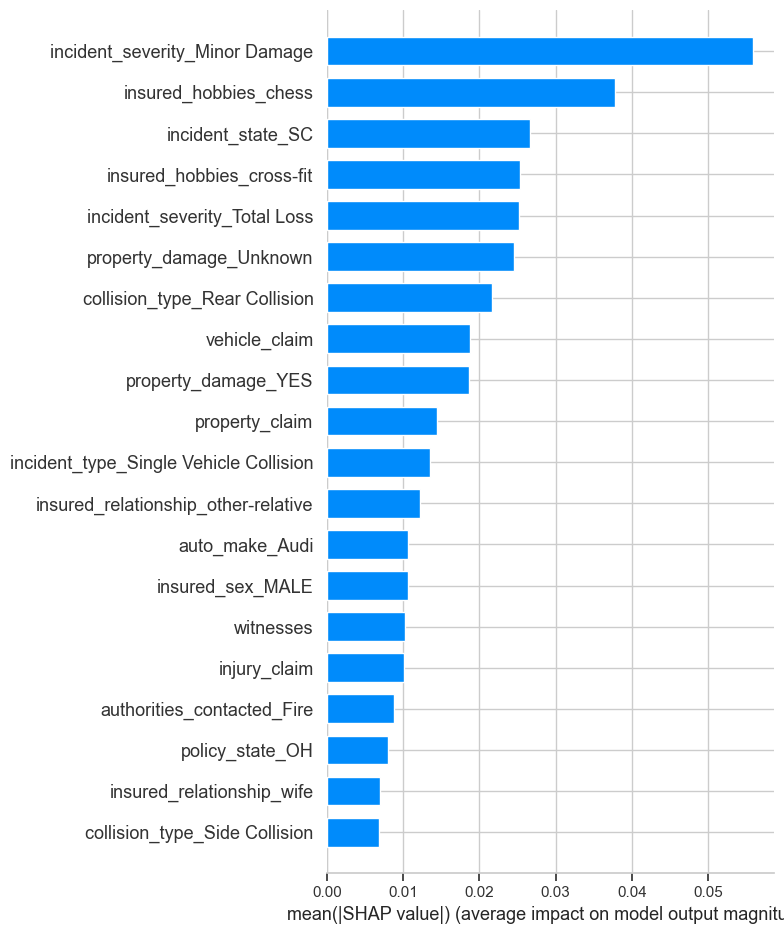

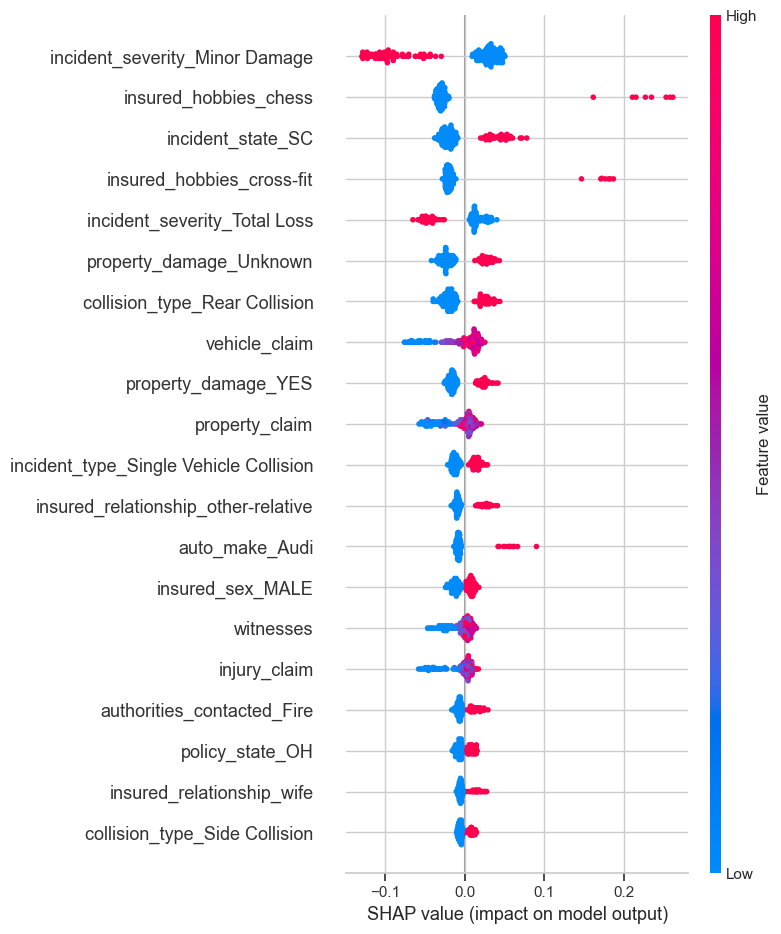

In [36]:
import shap
import numpy as np

# 1) échantillon test
X_test_sample = X_test.sample(min(200, len(X_test)), random_state=42)

# 2) explainer
explainer = shap.TreeExplainer(final_model)

# 3) shap values
shap_values = explainer.shap_values(X_test_sample)

# 4) rendre ça robuste selon le type/shape renvoyé
# - parfois shap_values = list [classe0, classe1]
# - parfois shap_values = ndarray (n_samples, n_features, n_classes)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]  # OK dans ce cas
else:
    shap_values = np.array(shap_values)
    if shap_values.ndim == 3:
        # (n_samples, n_features, n_classes)
        shap_values_class1 = shap_values[:, :, 1]
    elif shap_values.ndim == 2:
        # déjà (n_samples, n_features)
        shap_values_class1 = shap_values
    else:
        raise ValueError(f"Shape SHAP inattendue: {shap_values.shape}")

print("X_test_sample shape:", X_test_sample.shape)
print("shap_values_class1 shape:", shap_values_class1.shape)

# 5) plots
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=True)
shap.summary_plot(shap_values_class1, X_test_sample, show=True)
